In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.5/660.5 kB 3.7 MB/s eta 0:00:00


In [2]:
import os
import xml.etree.ElementTree as ET


In [3]:
#extract data from words.xml
def extract_data_from_xml(file_path):
  xml_path = os.path.join(file_path,'words.xml')
  tree = ET.parse(xml_path)
  root = tree.getroot()

  img_paths = []
  img_labels = []
  img_sizes = []
  bboxes = []

  for image in root:
    bbs_of_img = []
    labels_of_img = []

    for bbs in image.findall('taggedRectangles'):
      for bb in bbs:
        # check non-alphabet and non-number
        if not bb[0].text.isalnum():
          continue

        if ' ' in bb[0].text.lower() or ' ' in bb[0].text.lower():
          continue

        bbs_of_img.append([
            float(bb.attrib['x']),
            float(bb.attrib['y']),
            float(bb.attrib['width']),
            float(bb.attrib['height'])
        ])
        labels_of_img.append(bb[0].text.lower())


        img_path = os.path.join(file_path,image[0].text)
        img_paths.append(img_path)
        img_sizes.append((int(image[1].attrib['x']), int(image[1].attrib['y'])))
        bboxes.append(bbs_of_img)
        img_labels.append(labels_of_img)

  return img_paths, img_sizes, img_labels, bboxes

In [4]:
dataset_dir = '/content/drive/MyDrive/SceneTrialTrain'
img_paths,img_sizes,img_labels,bboxes = extract_data_from_xml(dataset_dir)

In [5]:
img_paths

['/content/drive/MyDrive/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG',
 '/content/drive/MyDrive/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG',
 '/content/drive/MyDrive/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG',
 '/content/drive/MyDrive/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG',
 '/content/drive/MyDrive/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG',
 '/content/drive/MyDrive/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG',
 '/content/drive/MyDrive/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG',
 '/content/drive/MyDrive/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG',
 '/content/drive/MyDrive/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG',
 '/content/drive/MyDrive/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG',
 '/content/drive/MyDrive/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG',
 '/content/drive/MyDrive/SceneTrialTrain/apanar_06.08.2002/IMG_1263.JPG',
 '/content/drive/MyDrive/SceneTrialTrain/apanar_06.08.2002/IMG_1265.JPG',
 '/content/drive/MyDrive/SceneTrialTra

In [6]:
# convert to yolov8 format
# example yolov8_labels format : 0 0.1 0.2 0.3 0.4

def convert_to_yolov8_format(img_paths,img_sizes,bboxes):
  yolov8_data = []
  for img_path,img_size,bbox in zip(img_paths,img_sizes,bboxes):
    yolov8_labels = []
    img_width,img_height = img_size
    for bb in bbox:
      x,y,w,h = bb
      x = (x + w/2)/img_width
      y = (y + h/2)/img_height
      w = w/img_width
      h = h/img_height
      class_id = 0

      label = f"{class_id} {x} {y} {w} {h}"
      yolov8_labels.append(label)
    yolov8_data.append((img_path,yolov8_labels))
  return yolov8_data


In [7]:
class_labels = ['text']
yolov8_data = convert_to_yolov8_format(
    img_paths,
    img_sizes,
    bboxes
)

In [8]:
#save data
import shutil
def save_data(data, src_img_dir, save_dir):
    # Create folder if not exists
    os.makedirs(save_dir, exist_ok=True)

    # Make images and labels folder
    os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'labels'), exist_ok=True)

    for image_path, yolov8_labels in data:
        # Copy image to images folder
        shutil.copy(
            os.path.join(src_img_dir, image_path),
            os.path.join(save_dir, 'images')
        )

        # Save labels to labels folder
        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, 'labels', f"{image_name}.txt"), 'w') as f:
            for label in yolov8_labels:
                f.write(f"{label}\n")

In [9]:
from sklearn.model_selection import train_test_split
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

train_data, test_data = train_test_split(
    yolov8_data,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

test_data, val_data = train_test_split(
    test_data,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

save_yolo_data_dir = 'yolo_data'
os.makedirs(save_yolo_data_dir, exist_ok=True)

save_train_dir = os.path.join(save_yolo_data_dir, 'train')
save_val_dir = os.path.join(save_yolo_data_dir, 'val')
save_val_dir = os.path.join(save_yolo_data_dir, 'val')
save_test_dir = os.path.join(save_yolo_data_dir, 'test')

save_data(train_data, dataset_dir, save_train_dir)
save_data(test_data, dataset_dir, save_val_dir)
save_data(val_data, dataset_dir, save_test_dir)

In [10]:
import yaml

data_yaml = {
    'path': '/content/yolo_data',
    'train': 'train/images',
    'test': 'test/images',
    'val': 'val/images',
    'nc': 1,
    'names': class_labels
}

yolo_yaml_path = os.path.join(save_yolo_data_dir, 'data.yml')

with open(yolo_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

In [11]:
#Training
from ultralytics import YOLO
yolo_yaml_path = '/content/yolo_data/data.yml'
model = YOLO('yolov8s.yaml').load('yolov8s.pt')




                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

100%|██████████| 21.5M/21.5M [00:00<00:00, 148MB/s] 


Transferred 355/355 items from pretrained weights


In [12]:
epochs = 200
imgsz = 1024
results = model.train(
    data=yolo_yaml_path,
    epochs=epochs,
    imgsz=imgsz,
    project='models',
    name='yolov8/detect/train'
)

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/yolo_data/data.yml, epochs=200, patience=50, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=models, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format

100%|██████████| 755k/755k [00:00<00:00, 26.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 136MB/s]


WARNING ⚠️ NMS time limit 0.550s exceeded
AMP: checks passed ✅


train: Scanning /content/yolo_data/train/labels... 221 images, 0 backgrounds, 0 corrupt: 100%|██████████| 221/221 [00:00<00:00, 1554.01it/s]

train: New cache created: /content/yolo_data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/yolo_data/val/labels... 118 images, 0 backgrounds, 0 corrupt: 100%|██████████| 118/118 [00:00<00:00, 850.46it/s]

val: New cache created: /content/yolo_data/val/labels.cache


Plotting labels to models/yolov8/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to models/yolov8/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      9.37G      2.004      5.461      1.772        118       1024: 100%|██████████| 14/14 [00:15<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

                   all        118        761      0.447      0.472      0.448       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      9.47G      1.107      1.618      1.158        165       1024: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        118        761      0.775      0.685      0.725      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      9.61G      1.099      1.334       1.14        155       1024: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        118        761      0.624      0.695      0.658      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      9.79G      1.149      1.255       1.19         83       1024: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        118        761       0.54      0.668       0.59      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      9.45G      1.161      1.236      1.187        106       1024: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.25s/it]

                   all        118        761      0.233      0.464      0.226      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      9.71G      1.161      1.131      1.189        111       1024: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        118        761      0.541      0.537      0.496      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      10.1G      1.224      1.114      1.193        136       1024: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

                   all        118        761      0.327      0.415      0.263      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      9.61G      1.164       1.07      1.183         61       1024: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

                   all        118        761      0.607      0.556      0.548      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      9.77G      1.148     0.9948      1.194        145       1024: 100%|██████████| 14/14 [00:09<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

                   all        118        761      0.469      0.511      0.427      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      9.77G      1.168      1.073      1.203        133       1024: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        118        761       0.72       0.66      0.663      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      9.91G      1.114     0.9623       1.14        135       1024: 100%|██████████| 14/14 [00:09<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all        118        761      0.669      0.595      0.562      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      9.77G      1.211      1.039      1.212        118       1024: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        118        761      0.724      0.733      0.707      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      10.6G      1.106     0.9424      1.145         59       1024: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        118        761      0.683      0.745      0.698      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      9.81G      1.061     0.8806      1.128         96       1024: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        118        761      0.741      0.721      0.737      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      9.53G      1.081     0.9117      1.137        168       1024: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        118        761      0.747      0.635      0.693      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      9.63G      1.103     0.8944      1.119         89       1024: 100%|██████████| 14/14 [00:09<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all        118        761      0.711       0.67      0.705       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      9.85G        1.1     0.8586      1.134         81       1024: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        118        761      0.722      0.625      0.675      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200       9.8G      1.026     0.8643      1.112        118       1024: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        118        761      0.728      0.736      0.748      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      9.75G      1.053     0.8805      1.118        130       1024: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        118        761      0.778      0.712      0.793       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200       9.6G      1.017     0.8516      1.112         97       1024: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        118        761       0.79      0.796      0.837      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      10.1G      1.018     0.8417      1.086        155       1024: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        118        761       0.83      0.812      0.859      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      9.53G       1.06     0.8394      1.086        121       1024: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        118        761      0.855      0.802      0.862      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200       9.6G      1.015     0.8072      1.083        155       1024: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        118        761      0.844      0.842      0.881      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      9.71G      0.983     0.8189      1.091        112       1024: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all        118        761      0.852      0.874      0.902      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      9.83G     0.9607     0.7693      1.064        107       1024: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        118        761      0.811      0.838       0.87      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200       9.8G     0.9868     0.7809      1.085         92       1024: 100%|██████████| 14/14 [00:09<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all        118        761       0.83      0.815      0.875       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      9.81G     0.9378     0.7687      1.085         89       1024: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        118        761      0.808      0.777      0.836      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      9.49G     0.9975     0.7649      1.088        175       1024: 100%|██████████| 14/14 [00:09<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all        118        761      0.871      0.862      0.917      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      9.77G     0.9744     0.7665      1.074        117       1024: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all        118        761      0.848      0.782      0.832      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      9.79G      0.965     0.7502      1.078        132       1024: 100%|██████████| 14/14 [00:09<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        118        761      0.839      0.849      0.863      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      9.76G     0.9589     0.7788       1.06        139       1024: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        118        761      0.899      0.853      0.921      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      10.2G     0.9864     0.7738      1.068        130       1024: 100%|██████████| 14/14 [00:09<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        118        761      0.856      0.875      0.903      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      10.2G     0.9351     0.7573      1.051        108       1024: 100%|██████████| 14/14 [00:09<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        118        761      0.892      0.858      0.912      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      10.2G      1.008     0.7991      1.076         92       1024: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        118        761       0.88      0.877      0.907      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      10.3G     0.9535     0.7169      1.035        131       1024: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.33it/s]

                   all        118        761      0.887      0.894      0.926      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      9.78G     0.9198     0.7388      1.039         90       1024: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        118        761      0.853      0.846      0.885       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      10.2G     0.8903     0.7205      1.046        113       1024: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        118        761      0.885      0.903       0.92      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200       9.6G     0.9013     0.6782      1.034        108       1024: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        118        761      0.882      0.895      0.932      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      9.87G     0.9202     0.6894      1.034         97       1024: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        118        761      0.849      0.906      0.922      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      9.59G       0.94     0.7057      1.055         67       1024: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        118        761      0.891      0.913      0.946      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200        10G     0.9384     0.7121       1.03        136       1024: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        118        761      0.819      0.901      0.909      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200        10G      0.904     0.6835       1.05        102       1024: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        118        761      0.878       0.94      0.955      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      9.77G     0.8852     0.6776      1.035        131       1024: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        118        761      0.902      0.895      0.942      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      9.71G     0.8699     0.6308      1.032        116       1024: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        118        761      0.924       0.89      0.942      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      9.67G     0.8789     0.6539      1.021        119       1024: 100%|██████████| 14/14 [00:09<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        118        761      0.924      0.904      0.951      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      9.88G     0.8855     0.6489      1.039        121       1024: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        118        761      0.897       0.89      0.948       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      9.58G     0.8628     0.6312      1.028        111       1024: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        118        761        0.9      0.912      0.938      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      10.2G     0.8627     0.6145          1        115       1024: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        118        761      0.901      0.934      0.953      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      9.96G     0.8651     0.6239      1.003         88       1024: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        118        761      0.942      0.913      0.963      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      9.79G     0.8294     0.6069      1.015         92       1024: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        118        761      0.926      0.948      0.965      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      10.2G     0.8502     0.6147      1.012        142       1024: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        118        761      0.939      0.943      0.967      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      9.56G     0.8553     0.6077     0.9998         99       1024: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        118        761      0.931      0.945      0.965      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      9.59G     0.8312     0.6319      1.002         84       1024: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        118        761      0.921      0.947      0.968      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      10.1G     0.8375     0.6177      1.006         91       1024: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        118        761      0.917      0.919      0.961      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      10.2G     0.8246     0.6047     0.9959         89       1024: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        118        761      0.915       0.93      0.966      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      9.79G      0.832     0.5769     0.9971         93       1024: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        118        761      0.931      0.924      0.961      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      9.92G     0.8226      0.588     0.9872        145       1024: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        118        761      0.931      0.937      0.962      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200       9.8G     0.7567     0.5526     0.9657        132       1024: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

                   all        118        761      0.926       0.94       0.96      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      9.99G     0.7805     0.5657     0.9823        115       1024: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        118        761      0.938       0.94      0.973      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      9.84G     0.8257     0.5815     0.9893        150       1024: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        118        761      0.913      0.908      0.958      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      9.96G     0.7978      0.543     0.9699        115       1024: 100%|██████████| 14/14 [00:09<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        118        761      0.908      0.925      0.964      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      10.2G     0.7742     0.5551     0.9765        113       1024: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        118        761      0.939       0.93      0.968      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      10.2G      0.787     0.5443      0.976        140       1024: 100%|██████████| 14/14 [00:09<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all        118        761      0.942      0.949      0.976      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      9.85G     0.8086     0.5607     0.9786        101       1024: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        118        761      0.934      0.955      0.969      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      10.1G     0.7829     0.5728      1.004         79       1024: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        118        761      0.927      0.961       0.97      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      9.64G     0.7759     0.5261     0.9757        123       1024: 100%|██████████| 14/14 [00:09<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        118        761      0.935      0.965      0.976      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200       9.7G     0.7862     0.5605     0.9981         69       1024: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]

                   all        118        761       0.94      0.954      0.974      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      9.58G     0.7998     0.5464     0.9849         87       1024: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        118        761      0.937      0.958      0.977      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      9.42G     0.7661     0.5409      0.974         85       1024: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        118        761      0.953       0.95      0.978      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      9.79G     0.7766      0.553     0.9884        196       1024: 100%|██████████| 14/14 [00:09<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

                   all        118        761      0.936      0.963      0.972      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200       9.7G     0.7773     0.5722     0.9929         98       1024: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        118        761      0.933      0.961      0.971      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      9.81G     0.8039     0.5474     0.9823        106       1024: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        118        761      0.938      0.957      0.977      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      9.82G     0.7444     0.5349     0.9742        109       1024: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        118        761      0.947      0.959      0.979       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      9.61G     0.7768     0.5468     0.9756        104       1024: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        118        761      0.944      0.966      0.976      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      9.59G     0.7821     0.5382     0.9639        143       1024: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        118        761      0.942      0.961      0.973      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200        10G     0.7406     0.5324     0.9663        116       1024: 100%|██████████| 14/14 [00:10<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        118        761      0.938      0.968      0.974      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      10.1G      0.752     0.5204     0.9749         41       1024: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        118        761      0.942      0.974      0.978       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      9.63G     0.7568     0.5136     0.9695        144       1024: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        118        761      0.938      0.952      0.966      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      9.81G     0.7513     0.5225     0.9739        102       1024: 100%|██████████| 14/14 [00:11<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        118        761       0.94      0.966      0.978      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      9.61G     0.7593     0.5207     0.9635        113       1024: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        118        761      0.944      0.966      0.974      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      9.98G     0.7279     0.4868     0.9611         70       1024: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        118        761      0.938      0.961      0.971      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      10.2G     0.7504     0.5164     0.9626        108       1024: 100%|██████████| 14/14 [00:09<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        118        761      0.945      0.961      0.979      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200       9.6G     0.7669     0.5227      0.962        108       1024: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        118        761      0.949      0.962      0.981      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      9.51G     0.7388     0.5068     0.9654        101       1024: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        118        761      0.935      0.967      0.976      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      10.2G     0.7382     0.5205     0.9552        146       1024: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        118        761      0.962      0.958      0.981        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      10.3G     0.7235     0.5038     0.9459        147       1024: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all        118        761      0.955      0.972      0.979      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      10.2G      0.745     0.5071     0.9693         79       1024: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        118        761      0.945      0.973      0.976      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      9.96G     0.7178     0.5073     0.9648         61       1024: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        118        761      0.952      0.976      0.979      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      9.98G     0.7262      0.489     0.9571        153       1024: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        118        761      0.941      0.974      0.979      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      9.62G     0.7284     0.5027     0.9513         98       1024: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        118        761      0.949      0.961      0.978      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200       9.6G     0.6978     0.4849     0.9461         80       1024: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        118        761      0.949       0.96      0.979      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200       9.5G     0.7254     0.4834     0.9385         96       1024: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        118        761      0.948      0.978      0.981      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200       9.6G     0.7062     0.4888      0.948         84       1024: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        118        761      0.969      0.978      0.986      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      9.77G     0.6985     0.4739     0.9412        147       1024: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        118        761      0.968      0.978      0.988      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      9.62G     0.7047     0.4788     0.9498        131       1024: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        118        761      0.967      0.979      0.988       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200        10G     0.6855     0.4745     0.9419        128       1024: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        118        761      0.957      0.962      0.984       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200        10G     0.6746     0.4873     0.9539         87       1024: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        118        761      0.956      0.974      0.984      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200        10G     0.7229     0.4873     0.9737        109       1024: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        118        761      0.959      0.979      0.988      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      9.89G     0.7042     0.4854     0.9427        146       1024: 100%|██████████| 14/14 [00:09<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        118        761      0.963      0.978      0.988      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      10.2G     0.6899     0.4722     0.9321        113       1024: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        118        761      0.957      0.972      0.985       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      9.58G     0.6964     0.4928     0.9614        109       1024: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all        118        761      0.951      0.975      0.984      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      9.87G     0.6861     0.4645     0.9462         90       1024: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        118        761      0.966      0.985      0.989       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200       9.7G     0.6991     0.4622     0.9385        106       1024: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        118        761      0.963      0.987      0.989      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      10.2G     0.6683     0.4585     0.9335        151       1024: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        118        761      0.977      0.983      0.988      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      9.85G     0.7128     0.4763     0.9631         96       1024: 100%|██████████| 14/14 [00:09<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        118        761      0.975      0.986      0.989      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      9.67G     0.6709     0.4453     0.9224        152       1024: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        118        761       0.97      0.987      0.989      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      9.99G     0.6733     0.4453     0.9308        105       1024: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        118        761       0.95      0.983      0.986      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      9.54G     0.6719     0.4452     0.9383         70       1024: 100%|██████████| 14/14 [00:11<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        118        761      0.967      0.986      0.988      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      10.2G     0.7041     0.4634     0.9487        117       1024: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        118        761      0.973      0.981      0.989      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      9.43G     0.6757     0.4513     0.9413        122       1024: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all        118        761      0.969      0.988      0.986      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      9.59G     0.6847     0.4353     0.9304        146       1024: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        118        761      0.957      0.984      0.982      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      9.78G     0.6736     0.4443     0.9369        120       1024: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        118        761      0.963      0.989      0.987      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      9.64G     0.6505     0.4323     0.9288        110       1024: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        118        761       0.98       0.97       0.99      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      10.2G     0.6514     0.4312     0.9265         93       1024: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        118        761      0.969      0.976      0.988      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      9.77G     0.6504       0.44     0.9271         76       1024: 100%|██████████| 14/14 [00:09<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        118        761      0.969      0.988      0.988      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      9.64G     0.6675     0.4403     0.9298         92       1024: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        118        761       0.97      0.984      0.989       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200       9.8G     0.6344     0.4182     0.9189        160       1024: 100%|██████████| 14/14 [00:09<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

                   all        118        761      0.972      0.972      0.989       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      9.82G     0.6421     0.4123     0.9299        134       1024: 100%|██████████| 14/14 [00:09<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        118        761      0.975      0.977      0.987       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      9.46G     0.6502      0.425     0.9109        132       1024: 100%|██████████| 14/14 [00:09<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        118        761      0.973      0.986      0.989      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      9.79G     0.6641     0.4402     0.9272        226       1024: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        118        761      0.971      0.982       0.99      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200        10G     0.6438     0.4232     0.9391        108       1024: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all        118        761      0.975      0.985       0.99      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200        10G      0.618     0.4152     0.9134        101       1024: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        118        761       0.98      0.984       0.99      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200       9.7G     0.6213     0.4034     0.8974        105       1024: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        118        761      0.982      0.985      0.989      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      9.86G     0.6232     0.4291     0.9255        124       1024: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        118        761      0.978      0.985       0.99      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      9.76G     0.6412     0.4529     0.9318         86       1024: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        118        761      0.977       0.98      0.989      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200        10G     0.6122     0.4065     0.9158        114       1024: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        118        761      0.969      0.983      0.989      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      9.58G     0.6124     0.4204     0.9133        114       1024: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        118        761      0.969      0.989      0.989      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      10.3G     0.6065     0.4041     0.9108        165       1024: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        118        761      0.971      0.989      0.989      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      9.58G     0.6231     0.4041     0.9179         94       1024: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all        118        761      0.967      0.979      0.989      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      9.85G     0.6142     0.4172     0.9197        103       1024: 100%|██████████| 14/14 [00:09<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        118        761      0.975      0.981       0.99      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      9.76G     0.6232     0.4075     0.9162        153       1024: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        118        761      0.978      0.979       0.99      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      9.57G     0.6258     0.4069     0.9044        215       1024: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]

                   all        118        761      0.973      0.982       0.99      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200       9.7G     0.6047     0.3974     0.9097        110       1024: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        118        761      0.979      0.988       0.99       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      9.79G       0.64     0.4235     0.9402         92       1024: 100%|██████████| 14/14 [00:09<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        118        761      0.978      0.986       0.99      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      9.58G     0.6079      0.397     0.9136        135       1024: 100%|██████████| 14/14 [00:09<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        118        761      0.971      0.983      0.991      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      9.78G     0.6237     0.4147     0.9034        163       1024: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        118        761      0.978      0.982       0.99      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      9.97G     0.5984     0.3997     0.9113         73       1024: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        118        761      0.972      0.988       0.99       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      10.2G     0.6024     0.3962     0.9088        133       1024: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        118        761      0.965       0.99      0.989      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      9.77G     0.6051     0.3949     0.9091        126       1024: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        118        761      0.969      0.991      0.989      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      10.3G     0.5951      0.391     0.9139         78       1024: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        118        761      0.973      0.988      0.991      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      10.2G     0.6068     0.3874     0.9107        135       1024: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        118        761      0.978      0.984      0.992      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      9.72G     0.5939      0.397     0.9146         71       1024: 100%|██████████| 14/14 [00:09<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        118        761      0.983       0.98      0.992      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      9.64G     0.5984     0.3823     0.9093         92       1024: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        118        761      0.978      0.986      0.991      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      9.59G     0.6024     0.3941     0.9117        121       1024: 100%|██████████| 14/14 [00:09<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        118        761       0.98      0.987      0.991      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      9.96G     0.5825     0.3856     0.9038         73       1024: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        118        761       0.98      0.989      0.992      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      9.85G     0.5679      0.387     0.9046         83       1024: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        118        761      0.982      0.982      0.993      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      10.2G     0.5894     0.3836     0.9037        102       1024: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        118        761      0.983      0.986      0.992      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      9.61G     0.5621     0.3698     0.9079        133       1024: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        118        761      0.978      0.992      0.992      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200       9.8G     0.5754     0.3847       0.92        157       1024: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        118        761      0.981      0.986      0.993      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      9.84G     0.5677     0.3777     0.9083        126       1024: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all        118        761      0.982      0.988      0.993      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      9.58G     0.5739     0.3637     0.9014         97       1024: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        118        761      0.986      0.987      0.993      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      9.61G     0.5442     0.3651     0.8968         81       1024: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        118        761      0.989      0.984      0.993      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      9.81G     0.5691     0.3646     0.8889        110       1024: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        118        761      0.988      0.984      0.992      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      9.61G     0.5692     0.3716     0.8956         88       1024: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        118        761      0.983      0.992      0.992      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      9.77G     0.5521     0.3721     0.8996         92       1024: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        118        761      0.983      0.991      0.992      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      9.99G     0.5501     0.3497     0.8866         96       1024: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        118        761      0.981      0.989      0.992      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200       9.8G     0.5387     0.3469      0.882        116       1024: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        118        761      0.983      0.989      0.993      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      9.49G     0.5365     0.3508     0.8952         91       1024: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        118        761      0.981      0.989      0.992      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      9.63G     0.5538     0.3605     0.8972         96       1024: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        118        761      0.984      0.988      0.992      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      9.84G     0.5381     0.3711     0.9025        103       1024: 100%|██████████| 14/14 [00:09<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        118        761      0.988      0.982      0.993      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      10.2G     0.5462     0.3606     0.8899        106       1024: 100%|██████████| 14/14 [00:09<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        118        761      0.987      0.986      0.993      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      10.2G     0.5439     0.3569     0.9008        123       1024: 100%|██████████| 14/14 [00:09<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        118        761      0.986      0.986      0.993      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      9.84G     0.5483     0.3594      0.884         82       1024: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        118        761      0.984      0.985      0.993      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      10.2G     0.5522     0.3598     0.8936         55       1024: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        118        761      0.983      0.987      0.993      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      9.79G     0.5311      0.356      0.894        106       1024: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        118        761      0.986      0.987      0.993      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      9.79G     0.5338     0.3481     0.8965         95       1024: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        118        761      0.989      0.986      0.993      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      9.82G     0.5358     0.3541     0.8999        129       1024: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        118        761      0.986      0.988      0.993      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      9.63G     0.5251     0.3476      0.897        102       1024: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        118        761      0.985      0.988      0.993      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200       9.7G     0.5385     0.3431     0.8999         81       1024: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        118        761      0.987      0.989      0.993        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      9.46G     0.5353     0.3515     0.8955         89       1024: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        118        761      0.989      0.989      0.993      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200        10G     0.5231     0.3439      0.887        152       1024: 100%|██████████| 14/14 [00:09<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

                   all        118        761      0.989      0.989      0.993      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200        10G     0.5149     0.3391     0.8865         69       1024: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all        118        761      0.988      0.986      0.992        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      9.58G     0.5138     0.3375     0.8854        115       1024: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        118        761      0.986      0.985      0.993      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      9.93G     0.5106     0.3385     0.8916         64       1024: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        118        761      0.987      0.986      0.993      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      9.83G     0.5326     0.3456     0.8802        141       1024: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        118        761      0.985      0.989      0.993      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200       9.8G     0.5121     0.3359     0.8843         98       1024: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        118        761      0.984      0.992      0.993       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      9.77G     0.5018     0.3324      0.886         95       1024: 100%|██████████| 14/14 [00:09<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        118        761      0.984      0.992      0.993       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200       9.8G     0.4938     0.3291     0.8826        125       1024: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        118        761      0.986      0.991      0.993      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      10.2G     0.5103     0.3379      0.878        129       1024: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

                   all        118        761      0.986      0.991      0.993      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      10.2G     0.4806     0.3281     0.8761        113       1024: 100%|██████████| 14/14 [00:12<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        118        761      0.984      0.989      0.993      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      9.77G     0.5011     0.3276     0.8911        148       1024: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        118        761      0.984      0.989      0.993      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      9.96G     0.5026     0.3269     0.8932        113       1024: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

                   all        118        761      0.991      0.987      0.993      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      9.81G     0.5135     0.3371     0.8871         93       1024: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        118        761      0.987      0.984      0.993      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      9.77G     0.4988     0.3257     0.8766        113       1024: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        118        761      0.991      0.984      0.993      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      10.2G     0.5104     0.3321     0.8848         66       1024: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        118        761      0.989      0.984      0.993      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      9.95G     0.5091     0.3345     0.8758        140       1024: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        118        761      0.988      0.986      0.993      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      9.58G     0.4889     0.3269      0.876         94       1024: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        118        761      0.989      0.986      0.993       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      9.77G     0.4859     0.3168      0.867         95       1024: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        118        761      0.989      0.986      0.993      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      10.2G     0.4735      0.321     0.8793        114       1024: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        118        761       0.99      0.987      0.993      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200       9.6G     0.4853     0.3232      0.881        134       1024: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        118        761      0.989      0.988      0.994       0.92


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      9.75G     0.4789     0.3317     0.8421         41       1024: 100%|██████████| 14/14 [00:14<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        118        761      0.987      0.989      0.993      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200       9.8G     0.4707     0.3242      0.853         50       1024: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        118        761      0.988      0.989      0.993      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      10.1G     0.4581     0.3108     0.8441         38       1024: 100%|██████████| 14/14 [00:09<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all        118        761      0.987      0.989      0.993      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      10.2G      0.442     0.3092     0.8412         54       1024: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        118        761      0.988      0.989      0.993      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      10.1G     0.4462     0.3041     0.8486         71       1024: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        118        761      0.986      0.989      0.993       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      9.78G     0.4442     0.2952     0.8425         84       1024: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        118        761      0.988      0.988      0.994      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      10.1G     0.4365     0.2956     0.8475         52       1024: 100%|██████████| 14/14 [00:09<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        118        761      0.988      0.988      0.994      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      9.79G     0.4346     0.3029       0.84         82       1024: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

                   all        118        761      0.992      0.987      0.994      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      9.55G     0.4426        0.3     0.8358         63       1024: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        118        761      0.992      0.988      0.994      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      9.79G     0.4291     0.2843     0.8295         67       1024: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        118        761      0.992      0.988      0.994      0.928



200 epochs completed in 0.856 hours.
Optimizer stripped from models/yolov8/detect/train/weights/last.pt, 22.6MB
Optimizer stripped from models/yolov8/detect/train/weights/best.pt, 22.6MB

Validating models/yolov8/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


                   all        118        761      0.992      0.988      0.994      0.928
Speed: 0.4ms preprocess, 10.7ms inference, 0.0ms loss, 12.4ms postprocess per image
Results saved to models/yolov8/detect/train


In [13]:
from ultralytics import YOLO

model_path = '/content/models/yolov8/detect/train/weights/best.pt'
model = YOLO(model_path)

metrics = model.val()


Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/yolo_data/val/labels.cache... 118 images, 0 backgrounds, 0 corrupt: 100%|██████████| 118/118 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:14<00:00,  1.77s/it]


                   all        118        761      0.991      0.988      0.994      0.928
Speed: 1.7ms preprocess, 22.3ms inference, 0.0ms loss, 11.4ms postprocess per image
Results saved to runs/detect/val


In [14]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [15]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.9 MB/s eta 0:00:00


In [16]:
import os
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import random
import cv2
import timm
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

In [17]:
def split_bounding_boxes(img_paths, img_labels, bboxes, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    count = 0
    labels = []  # List to store labels

    for img_path, img_label, bbs in zip(img_paths, img_labels, bboxes):
        img = Image.open(img_path)

        for label, bb in zip(img_label, bbs):
            # Crop image
            cropped_img = img.crop((bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]))

            # Filter out if 90% of the cropped image is black or white
            if np.mean(cropped_img) < 35 or np.mean(cropped_img) > 220:
                continue

            if cropped_img.size[0] < 10 or cropped_img.size[1] < 10:
                continue

            # Save image
            filename = f"{count:06d}.jpg"
            cropped_img.save(os.path.join(save_dir, filename))

            new_img_path = os.path.join(save_dir, filename)

            label = new_img_path + '\t' + label

            labels.append(label)  # Append label to the list

            count += 1

    print(f"Created {count} images")

    # Write labels to a text file
    with open(os.path.join(save_dir, 'labels.txt'), 'w',encoding='utf-8') as f:
        for label in labels:
            f.write(f"{label}\n")

save_dir = 'ocr_dataset'
split_bounding_boxes(img_paths, img_labels, bboxes, save_dir)

Created 11314 images


In [18]:
#read data
root_dir = save_dir

img_paths = []
labels = []
with open(os.path.join(root_dir,'labels.txt'),'r',encoding='utf-8') as f:
  for label in f :
    labels.append(label.strip().split('\t')[1])
    img_paths.append(label.strip().split('\t')[0])

print(f"total image {len(img_paths)}")

total image 11314


In [19]:
#letters = [char.split(".")[0].lower() for char in labels]
i = 0
for char in labels:
  print(char)
  i += 1
  if i == 5:
    break

self
adhesive
address
labels
36


In [20]:
letters = [char.lower() for char in labels]

In [21]:
letters = "".join(letters)
print(letters)


selfadhesiveaddresslabels36250onarollselfadhesiveaddresslabels36250onarollselfadhesiveaddresslabels36250onarollselfadhesiveaddresslabels36250onarollselfadhesiveaddresslabels36250onarollselfadhesiveaddresslabels36250onarollselfadhesiveaddresslabels36250onarollselfadhesiveaddresslabels36250onarollselfadhesiveaddresslabels36250onarollselfadhesiveaddresslabels36250onarollselfadhesiveaddresslabels36250onarollnatwestgreekgastronomycookerywineslocaltoubrsspecialtiesfestiverecipesillustratedgreekgastronomycookerywineslocaltoubrsspecialtiesfestiverecipesillustratedgreekgastronomycookerywineslocaltoubrsspecialtiesfestiverecipesillustratedgreekgastronomycookerywineslocaltoubrsspecialtiesfestiverecipesillustratedgreekgastronomycookerywineslocaltoubrsspecialtiesfestiverecipesillustratedgreekgastronomycookerywineslocaltoubrsspecialtiesfestiverecipesillustratedgreekgastronomycookerywineslocaltoubrsspecialtiesfestiverecipesillustratedgreekgastronomycookerywineslocaltoubrsspecialtiesfestiverecipesillus

In [22]:
letters = sorted(list(set(list(letters))))
letters

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'é',
 'ñ']

In [23]:
chars = "".join(letters)
chars

'0123456789abcdefghijklmnopqrstuvwxyzéñ'

In [24]:
blank_char = '-'
chars += blank_char
vocab_size = len(chars)

In [25]:
print(vocab_size)

39


In [26]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {index: char for char, index in char_to_idx.items()}

In [27]:
max_label_len = max([len(label) for label in labels])
print(max_label_len)

14


In [28]:
max_label_len = max([len(label) for label in labels])

def encode(label, char_to_idx, max_label_len):
    encoded_labels = torch.tensor(
        [char_to_idx[char] for char in label],
        dtype=torch.int32
    )
    label_len = len(encoded_labels)
    lengths = torch.tensor(
        label_len,
        dtype=torch.int32
    )
    padded_labels = F.pad(
        encoded_labels,
        (0, max_label_len - label_len),
        value=0
    )

    return padded_labels, lengths

In [29]:
def decode(encoded_sequences, idx_to_char, blank_char='-'):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        for idx, token in enumerate(seq):
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    decoded_label.append(char)

        decoded_sequences.append(''.join(decoded_label))

    return decoded_sequences

In [30]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.Grayscale(num_output_channels=1),
        transforms.GaussianBlur(3),
        transforms.RandomAffine(degrees=1, shear=1),
        transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3),
        transforms.RandomRotation(degrees=2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
    'val': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
}

In [31]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [32]:
class STRDataset(Dataset):
    def __init__(
        self,
        X, y,
        char_to_idx,
        max_label_len,
        label_encoder=None,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(
                label,
                self.char_to_idx,
                self.max_label_len
            )
        return img, encoded_label, label_len

In [33]:
train_dataset = STRDataset(
    X_train, y_train,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['train']
)

val_dataset = STRDataset(
    X_val, y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)

test_dataset = STRDataset(
    X_test, y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)

train_batch_size = 32
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [34]:
class CRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3):
        super(CRNN, self).__init__()

        backbone = timm.create_model(
            'resnet101',
            in_chans=1,
            pretrained=True
        )
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Unfreeze the last few layers
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.lstm = nn.LSTM(
            512, hidden_size,
            n_layers, bidirectional=True, batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),
            nn.LogSoftmax(dim=2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)  # Flatten the feature map
        x = self.mapSeq(x)
        x, _ = self.lstm(x)
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2)  # Based on CTC

        return x

In [35]:
hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers
).to(device)

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [36]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for inputs, labels, labels_len in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

def fit(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.int32
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                5
            )
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

        scheduler.step()

    return train_losses, val_losses

In [37]:
epochs = 35
lr = 0.001
weight_decay = 1e-5
scheduler_step_size = int(epochs * 0.6)

criterion = nn.CTCLoss(blank=char_to_idx[blank_char], zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [39]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 1.6794	Val loss: 0.6062
EPOCH 2:	Train loss: 0.5092	Val loss: 0.2645
EPOCH 3:	Train loss: 0.3118	Val loss: 0.2368
EPOCH 4:	Train loss: 0.2685	Val loss: 0.2296
EPOCH 5:	Train loss: 0.2161	Val loss: 0.0776
EPOCH 6:	Train loss: 0.1307	Val loss: 0.0877
EPOCH 7:	Train loss: 0.1748	Val loss: 0.0810
EPOCH 8:	Train loss: 0.1633	Val loss: 0.1666
EPOCH 9:	Train loss: 0.1997	Val loss: 0.1211
EPOCH 10:	Train loss: 0.1427	Val loss: 0.0921
EPOCH 11:	Train loss: 0.1265	Val loss: 0.1272
EPOCH 12:	Train loss: 0.1313	Val loss: 0.0435
EPOCH 13:	Train loss: 0.1121	Val loss: 0.0465
EPOCH 14:	Train loss: 0.1380	Val loss: 0.0661
EPOCH 15:	Train loss: 0.0959	Val loss: 0.0207
EPOCH 16:	Train loss: 0.0748	Val loss: 0.0675
EPOCH 17:	Train loss: 0.0840	Val loss: 0.0548
EPOCH 18:	Train loss: 0.1116	Val loss: 0.0270
EPOCH 19:	Train loss: 0.0873	Val loss: 0.0354
EPOCH 20:	Train loss: 0.0625	Val loss: 0.0272
EPOCH 21:	Train loss: 0.0478	Val loss: 0.1155
EPOCH 22:	Train loss: 0.0550	Val loss: 0.01

In [42]:
def text_detection(img_path, text_det_model):
    text_det_results = text_det_model(img_path, verbose=False)[0]

    bboxes = text_det_results.boxes.xyxy.tolist()
    classes = text_det_results.boxes.cls.tolist()
    names = text_det_results.names
    confs = text_det_results.boxes.conf.tolist()

    return bboxes, classes, names, confs


In [41]:
def text_recognition(img, data_transforms, text_reg_model, idx_to_char, device):
    transformed_image = data_transforms(img)
    transformed_image = transformed_image.unsqueeze(0).to(device)
    text_reg_model.eval()

    with torch.no_grad():
        logits = text_reg_model(transformed_image).detach().cpu()

    text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)

    return text


In [43]:
def visualize_detections(img, detections):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')

    for bbox, detected_class, confidence, transcribed_text in detections:
        x1, y1, x2, y2 = bbox
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2))
        plt.text(
            x1, y1 - 10, f"{detected_class} ({confidence:.2f}): {transcribed_text}",
            fontsize=9, bbox=dict(facecolor='red', alpha=0.5)
        )

    plt.show()


In [56]:
def predict(img_path, data_transforms, text_det_model, text_reg_model, idx_to_char, device):
    # Detection
    bboxes, classes, names, confs = text_detection(img_path, text_det_model)

    # Load the image
    img = Image.open(img_path)

    predictions = []

    # Iterate through the results
    for bbox, cls, conf in zip(bboxes, classes, confs):
        x1, y1, x2, y2 = bbox
        confidence = conf
        detected_class = cls
        name = names[int(cls)]

        # Extract the detected object and crop it
        cropped_image = img.crop((x1, y1, x2, y2))

        transcribed_text = text_recognition(
            cropped_image, data_transforms, text_reg_model, idx_to_char, device
        )

        predictions.append((bbox, name, confidence, transcribed_text))

    visualize_detections(img, predictions)

    return predictions


In [57]:
path = '/content/yolo_data/train/images/IMG_1261.JPG'
model_detect_path = '/content/models/yolov8/detect/train/weights/best.pt'
model_detect = YOLO(model_path)

In [59]:
test_transform = data_transforms['val']

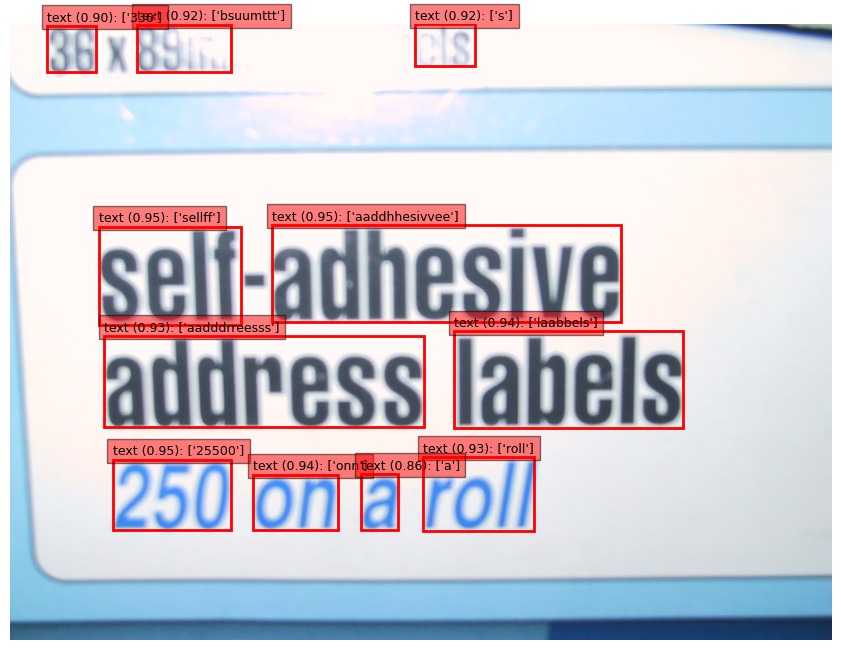

[([172.6237335205078, 394.0382385253906, 449.9992370605469, 586.8104248046875],
  'text',
  0.9461365938186646,
  ['sellff']),
 ([199.92254638671875, 847.931396484375, 429.89892578125, 985.9356689453125],
  'text',
  0.9454348683357239,
  ['25500']),
 ([510.7665100097656, 391.2618408203125, 1190.12646484375, 579.77392578125],
  'text',
  0.9453184008598328,
  ['aaddhhesivvee']),
 ([864.8723754882812, 597.9488525390625, 1309.64013671875, 786.1240234375],
  'text',
  0.9401073455810547,
  ['laabbels']),
 ([473.47296142578125,
   877.5369873046875,
   638.5152587890625,
   986.1784057617188],
  'text',
  0.9379678964614868,
  ['onn']),
 ([183.51144409179688, 606.8873901367188, 806.1962890625, 784.5924682617188],
  'text',
  0.9331446290016174,
  ['aadddrreesss']),
 ([804.644775390625, 842.7644653320312, 1020.73095703125, 986.5388793945312],
  'text',
  0.928810715675354,
  ['roll']),
 ([789.0462646484375,
   0.03877878189086914,
   904.5421752929688,
   81.74339294433594],
  'text',
  0.9

In [60]:
predict(path,test_transform,model_detect,model,idx_to_char,device)

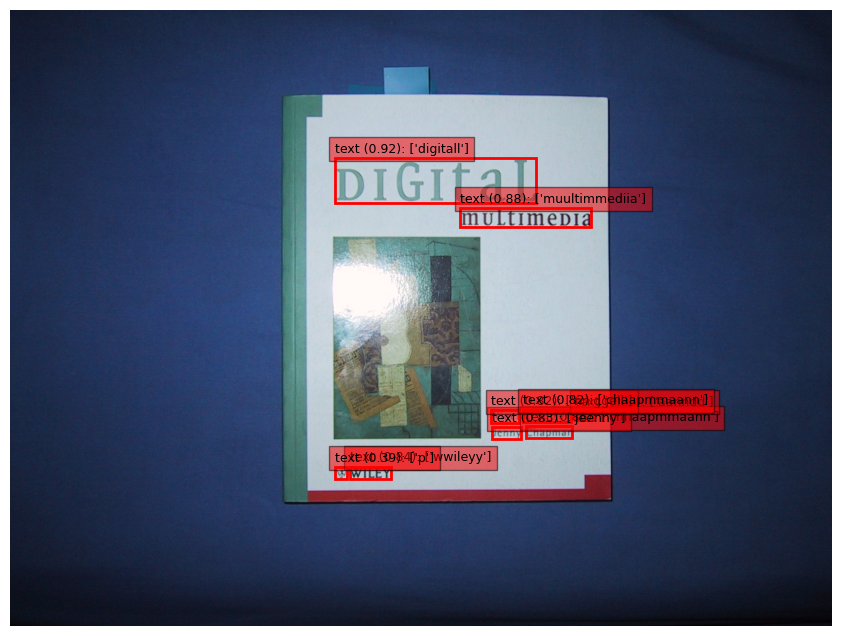

[([632.109375, 287.4814758300781, 1024.2359619140625, 375.660400390625],
  'text',
  0.9204786419868469,
  ['digitall']),
 ([876.205810546875, 384.99237060546875, 1131.812255859375, 422.593505859375],
  'text',
  0.8796727657318115,
  ['muultimmediia']),
 ([1004.1656494140625,
   810.5136108398438,
   1095.2056884765625,
   833.8868408203125],
  'text',
  0.8636978268623352,
  ['chhaapmmaann']),
 ([661.5349731445312, 888.9326171875, 741.5501708984375, 913.682373046875],
  'text',
  0.8437111377716064,
  ['wwileyy']),
 ([938.7586669921875, 812.7914428710938, 995.8389282226562, 835.1049194335938],
  'text',
  0.8284193873405457,
  ['jeenny']),
 ([1100.23193359375, 780.613037109375, 1136.32666015625, 798.4044189453125],
  'text',
  0.8270189762115479,
  ['aanndd']),
 ([936.8184814453125, 779.0030517578125, 990.709716796875, 803.9653930664062],
  'text',
  0.8203044533729553,
  ['nniggell']),
 ([999.3999633789062, 777.7616577148438, 1092.293212890625, 802.264892578125],
  'text',
  0.81794

In [61]:
path = '/content/yolo_data/train/images/IMG_1281.JPG'
predict(path,test_transform,model_detect,model,idx_to_char,device)